In [22]:
import sys, os, datetime, requests, re
sys.path.append("../../../")

In [156]:
import warnings

import pandas as pd
import numpy as np
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [66]:
tricrypto_genesis_block = 12821148
api = "https://api.thegraph.com/subgraphs/name/convex-community/tricrypto"

In [86]:
def denest_dict(nested_dict):
    denested_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            denested_dict.update(value)
        else:
            denested_dict.update({key: value})
    return denested_dict

In [129]:
def graph_query(block_start, block_end, block_step=25000):

  block_gte = block_start - 1
  block_lt = block_end
  
  list_data = []
  while True:

    print("query range: ", block_gte, block_lt)

    query = f"""
    {{
    exchangeEvents(
      first: 1000
      where: {{
        blockNumber_gt: {block_gte}
        blockNumber_lt: {block_lt}
      }}
    ) {{
          blockNumber
          timestamp
          assetPrices{{
            ethPrice
            btcPrice
            crv3cryptoUSD
            crv3cryptoBTC
            crv3cryptoETH
            indexNumUSD
            indexNumETH
            indexNumBTC
        }}  	
      }}
    }}
    """

    r = requests.post(api, json={'query': query})

    try:
      data = dict(r.json())['data']['exchangeEvents']
    except KeyError:
      print('No data.')
      break

    blocks_in_data = pd.DataFrame(data)['blockNumber'].astype(int)
    max_block = blocks_in_data.max()
    min_block = blocks_in_data.min()
    print(min_block, max_block)

    list_data.extend([denest_dict(i) for i in data])
    
    if max_block > block_end:
      print("reached max block.")
      break
    
    block_gte = max_block - 1
    block_lt = block_gte + block_step

  df = pd.DataFrame(list_data)

  df['blockNumber'] = df.blockNumber.astype('int')
  df['timestamp'] = df.timestamp.astype('int')
  df['crv3cryptoUSD'] = df.crv3cryptoUSD.astype('float')
  df['crv3cryptoBTC'] = df.crv3cryptoBTC.astype('float')
  df['crv3cryptoETH'] = df.crv3cryptoETH.astype('float')

  df['ethPrice'] = df.ethPrice.astype('float')
  df['btcPrice'] = df.btcPrice.astype('float')
  df['indexNumUSD'] = df.indexNumUSD.astype('float')
  df['indexNumETH'] = df.indexNumETH.astype('float')
  df['indexNumBTC'] = df.indexNumBTC.astype('float')

  df['time'] = df.timestamp.apply(datetime.datetime.fromtimestamp)

  df.set_index('time', inplace=True)
  df.drop_duplicates(inplace=True)  # remove any duplicate rows

  return df.loc[(df.blockNumber > block_start) & (df.blockNumber < block_end)]

In [130]:
# block_end should be latest block:
df = graph_query(block_start=tricrypto_genesis_block, block_end=14475722)

query range:  12821147 14475722
12835399 14472645
query range:  14472644 14497644
14472645 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720
query range:  14475719 14500719
14475720 14475720


In [135]:
df.sort_index(inplace=True)

Compare eth/btc delta and gamma with respect to crv3crypto delta and gamma.
delta: change of price between subsequent epochs
gamma: rate of change of price between subsequent price deltas

if gamma of eth is increasing and gamma of crv3crypto is decreasing: price acceleration of eth in USD would result in price deceleration of crv3crypto in USD: so-called negative gamma.

In [146]:
df_price_kinetics = df.copy()

# price delta
df_price_kinetics['eth_delta'] = df.ethPrice.diff()
df_price_kinetics['btc_delta'] = df.ethPrice.diff()
df_price_kinetics['crv3crypto_delta'] = df.crv3cryptoUSD.diff()

# price gamma
df_price_kinetics['eth_gamma'] = df_price_kinetics.eth_delta.diff()
df_price_kinetics['btc_gamma'] = df_price_kinetics.btc_delta.diff()
df_price_kinetics['crv3crypto_gamma'] = df_price_kinetics.crv3crypto_delta.diff()

df_price_kinetics.dropna(inplace=True)

df_price_kinetics[['eth_delta', 'eth_gamma', 'btc_delta', 'btc_gamma', 'crv3crypto_delta', 'crv3crypto_gamma']]

,eth_delta,eth_gamma,btc_delta,btc_gamma,crv3crypto_delta,crv3crypto_gamma
time,,,,,,
2021-07-20 00:47:51,-114.679200,-95.515521,-114.679200,-95.515521,-43.332053,-44.004987
2021-07-20 03:14:24,-5.522982,109.156218,-5.522982,109.156218,-0.473014,42.859039
2021-07-20 05:23:04,-66.057322,-60.534339,-66.057322,-60.534339,-20.603997,-20.130983
2021-07-21 04:42:45,30.972747,97.030069,30.972747,97.030069,-0.373201,20.230796
2021-07-21 20:56:14,218.292156,187.319409,218.292156,187.319409,76.255289,76.628491
...,...,...,...,...,...,...
2022-03-28 18:18:49,-11.273841,-10.789141,-11.273841,-10.789141,-1.822166,-1.745378
2022-03-28 18:19:35,-0.558704,10.715138,-0.558704,10.715138,-0.089763,1.732404
2022-03-28 18:20:25,-1.080504,-0.521800,-1.080504,-0.521800,-0.174822,-0.085059


Let's take eth: plotting eth delta vs crv3crypto delta and eth gamma vs crv3crypto gamma.

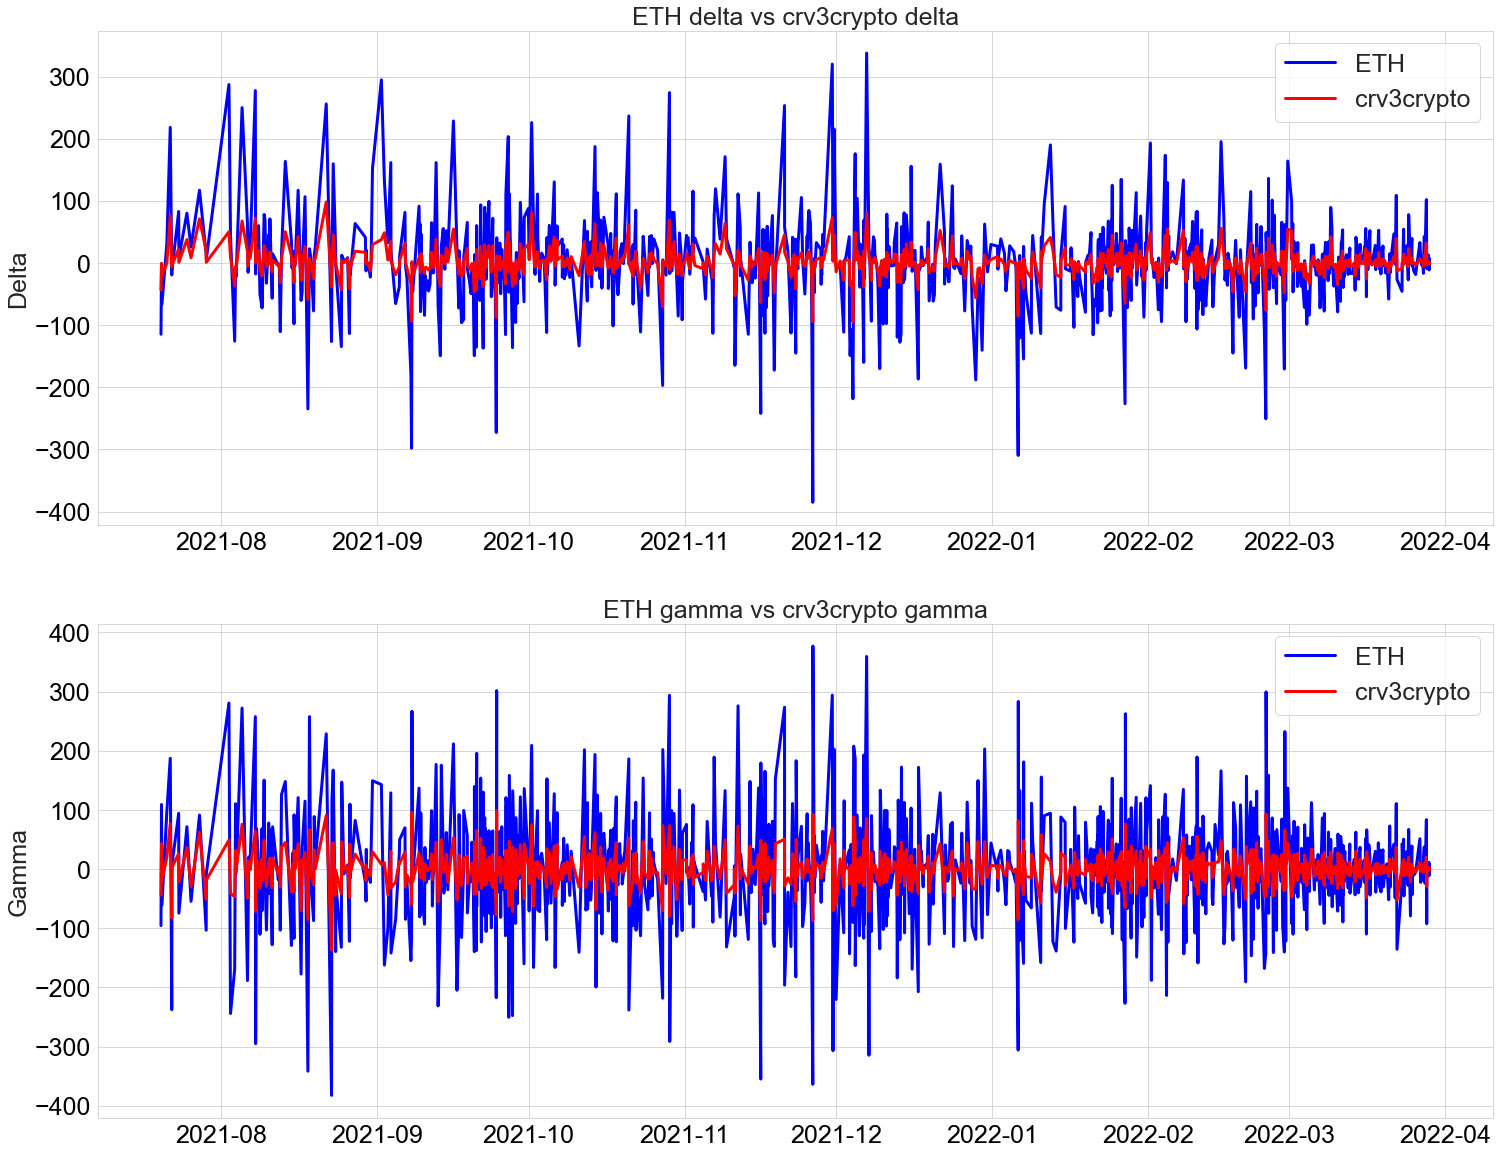

In [152]:
fig, axes = plt.subplots(2,1, figsize=(25, 20))

axes[0].plot(
    df_price_kinetics.index,
    df_price_kinetics.eth_delta,
    'b',
    lw=3,
    ms=10,
    label='ETH'
)
axes[0].plot(
    df_price_kinetics.index,
    df_price_kinetics.crv3crypto_delta,
    'r',
    lw=3,
    ms=10,
    label='crv3crypto'
)
axes[0].set_title("ETH delta vs crv3crypto delta", fontsize=25)
axes[0].set_ylabel("Delta", fontsize=25)

axes[1].plot(
    df_price_kinetics.index,
    df_price_kinetics.eth_gamma,
    'b',
    lw=3,
    ms=10,
    label='ETH'
)
axes[1].plot(
    df_price_kinetics.index,
    df_price_kinetics.crv3crypto_gamma,
    'r',
    lw=3,
    ms=10,
    label='crv3crypto'
)
axes[1].set_title("ETH gamma vs crv3crypto gamma", fontsize=25)
axes[1].set_ylabel("Gamma", fontsize=25)

for ax in axes:

    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
    ax.legend(fontsize=25);

Scatter plot of delta and gamma:

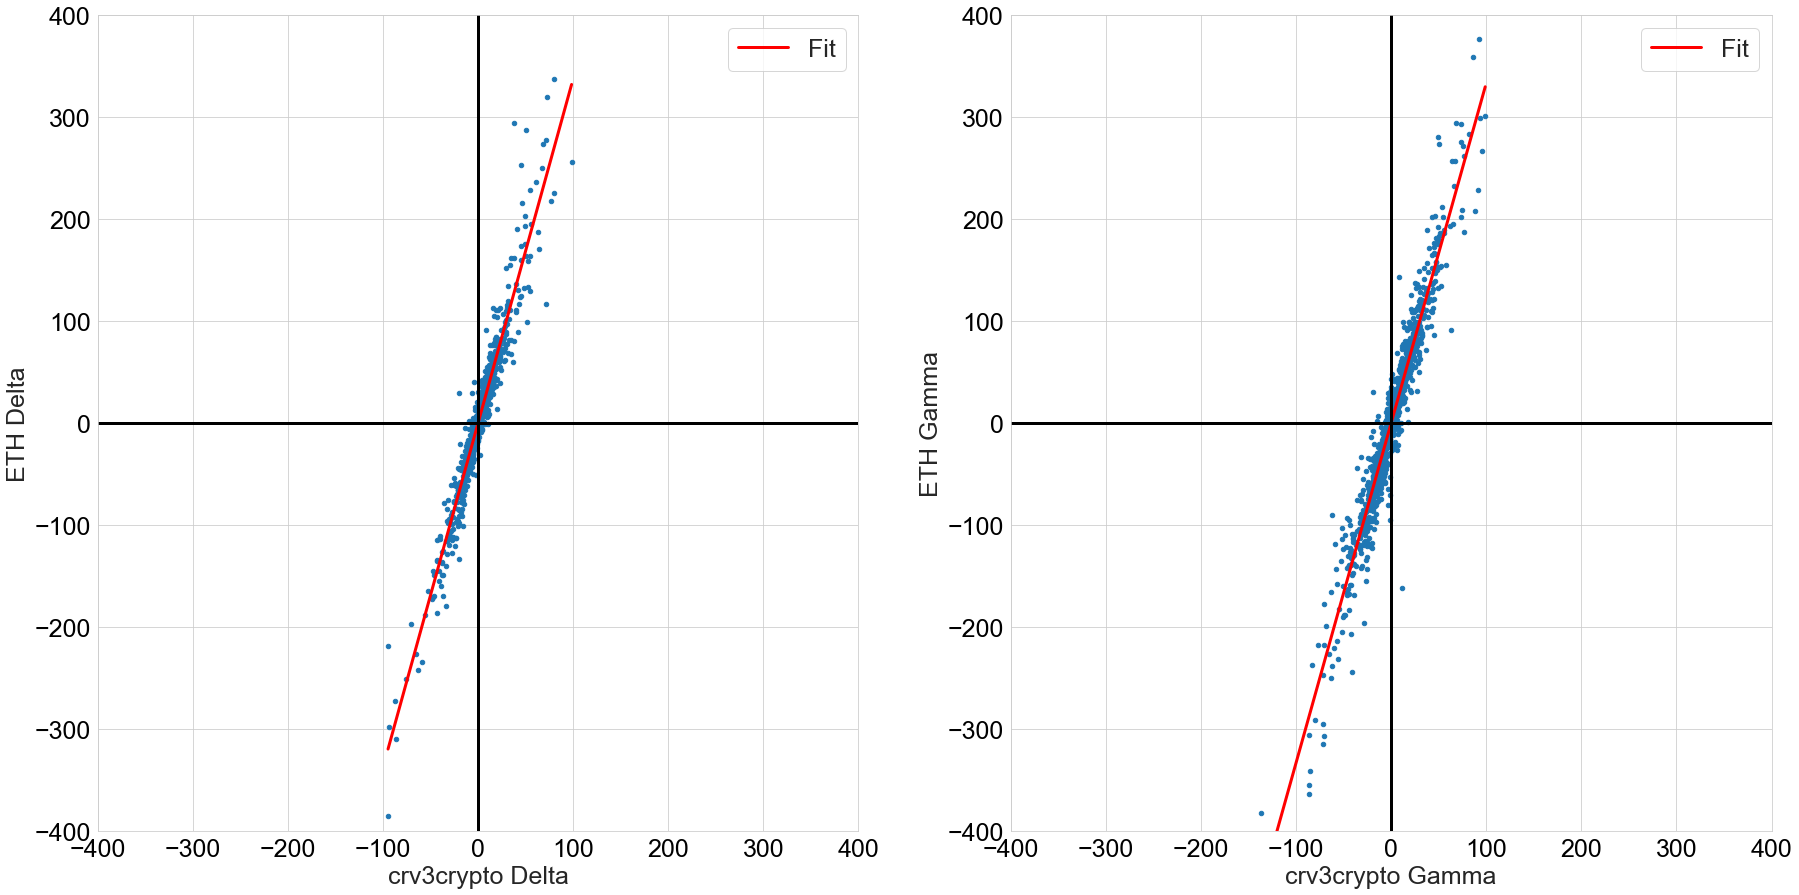

In [162]:
fig, axes = plt.subplots(1,2, figsize=(30, 15))

# delta
axes[0].scatter(
    df_price_kinetics.crv3crypto_delta,
    df_price_kinetics.eth_delta,
    20,
)
axes[0].set_xlabel("crv3crypto Delta", fontsize=25)
axes[0].set_ylabel("ETH Delta", fontsize=25)

axes[0].plot(
    np.unique(df_price_kinetics.crv3crypto_delta), 
    np.poly1d(np.polyfit(df_price_kinetics.crv3crypto_delta, df_price_kinetics.eth_delta, 1))(np.unique(df_price_kinetics.crv3crypto_delta)),
    lw=3,
    color='r',
    label='Fit'
)
axes[0].axhline(y=0, xmin=-400, xmax=400, color='k', lw=3)
axes[0].axvline(x=0, ymin=-400, ymax=400, color='k', lw=3)

# gamma
axes[1].scatter(
    df_price_kinetics.crv3crypto_gamma,
    df_price_kinetics.eth_gamma,
    20,
)
axes[1].set_xlabel("crv3crypto Gamma", fontsize=25)
axes[1].set_ylabel("ETH Gamma", fontsize=25)

axes[1].plot(
    np.unique(df_price_kinetics.crv3crypto_gamma), 
    np.poly1d(np.polyfit(df_price_kinetics.crv3crypto_gamma, df_price_kinetics.eth_gamma, 1))(np.unique(df_price_kinetics.crv3crypto_gamma)),
    lw=3,
    color='r',
    label='Fit'
)
axes[1].axhline(y=0, xmin=-400, xmax=400, color='k', lw=3)
axes[1].axvline(x=0, ymin=-400, ymax=400, color='k', lw=3)

for ax in axes:

    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
    ax.set_xlim([-400, 400])
    ax.set_ylim([-400, 400])
    ax.legend(fontsize=25);

Impermanent Loss: compare Index price at a certain deposit block to its current price. do the same for crv3crypto. plot them together.

In [136]:
deposited_at_block = 13545318
df_snippet = df.loc[df.blockNumber >= deposited_at_block]

In [155]:
seed_value = df_snippet.crv3cryptoUSD.iloc[0]  # total dollars
seed_num_dollars = 1/3 * seed_value
seed_num_eth = 1/3 * seed_value/df_snippet.ethPrice.iloc[0]
seed_num_btc = 1/3 * seed_value/df_snippet.btcPrice.iloc[0]

df_snippet['index_price'] = seed_num_dollars + seed_num_eth * df_snippet['ethPrice'] + seed_num_btc * df_snippet['btcPrice']
df_snippet[['crv3cryptoUSD', 'index_price']]

,crv3cryptoUSD,index_price
time,,
2021-11-04 15:26:49,1982.227339,1982.227339
2021-11-04 15:56:12,1981.904048,1981.905834
2021-11-05 02:58:47,1962.645940,1962.695123
2021-11-05 10:53:22,1973.516374,1973.519643
2021-11-06 07:45:20,1964.732378,1964.744973
...,...,...
2022-03-28 18:18:49,1645.102863,1653.788590
2022-03-28 18:19:35,1645.013101,1653.707853
2022-03-28 18:20:25,1644.838279,1653.551567


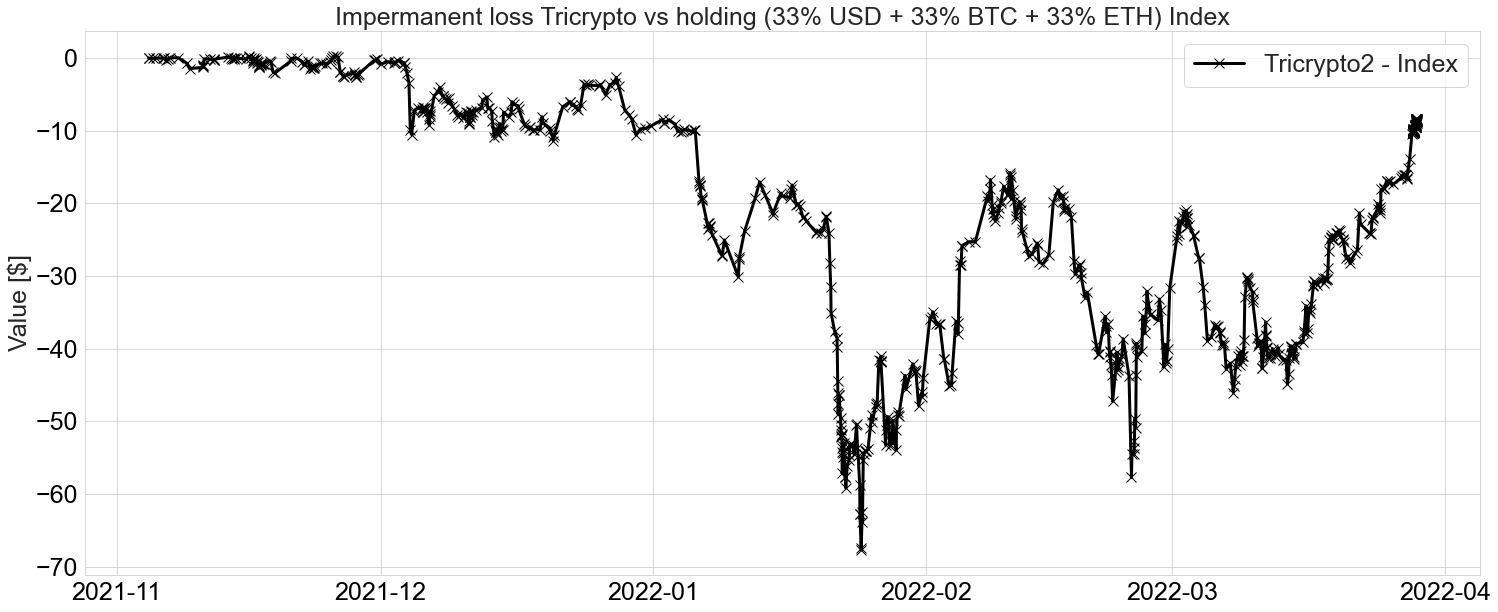

In [138]:
fig, ax = plt.subplots(1,1, figsize=(25, 10))

ax.plot(
    df_snippet.index,
    df_snippet.crv3cryptoUSD - df_snippet.index_price,
    'kx-',
    lw=3,
    ms=10,
    label='Tricrypto2 - Index'
)

ax.set_ylabel("Value [$]", fontsize=25)
ax.set_title("Impermanent loss Tricrypto vs holding (33% USD + 33% BTC + 33% ETH) Index", fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);